In [3]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib
import warnings
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')


# =============================
# Load image data from file
# =============================

In [4]:


print("\nLoading image data from 'Segmented_data.npz'...")
data = np.load('Segmented_data.npz')
x_train = data['x_train']
y_train = data['y_train']
x_val   = data['x_val']
y_val   = data['y_val']
x_test  = data['x_test']
y_test  = data['y_test']
class_names = data['class_names']
num_classes = data['num_classes']

print("Data loaded.")
print("Class names:", class_names, "num_classes:", num_classes)
print(f"Training samples: {x_train.shape[0]}")
print(f"Validation samples: {x_val.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")



Loading image data from 'Segmented_data.npz'...
Data loaded.
Class names: ['CRVO' 'DME' 'OTHER'] num_classes: 3
Training samples: 3190
Validation samples: 684
Test samples: 684


# =============================
# Load models
# =============================

In [5]:

print("\nLoading model 'model_1.keras'...")
model_1 = tf.keras.models.load_model('model_1.keras')
print("Loading model 'best_model_g.keras'...")
model_2 = tf.keras.models.load_model('best_model_g.keras')
print("Loading model 'Final_model.pkl'...")
model_3 = joblib.load('Final_model.pkl')
selected_indices = np.load('selected_indices.npy')


Loading model 'model_1.keras'...
Loading model 'best_model_g.keras'...
Loading model 'Final_model.pkl'...



# =============================
# Evaluate models and calculate metrics
# =============================


=== Model 1 (Before Optimization) Results ===
Validation Accuracy: 0.92251    Error Rate: 0.07749
Test Accuracy: 0.91667         Error Rate: 0.08333
Classification Report (Validation Data):
               precision    recall  f1-score   support

        CRVO       0.92      0.92      0.92       235
         DME       0.91      0.94      0.92       240
       OTHER       0.95      0.90      0.92       209

    accuracy                           0.92       684
   macro avg       0.92      0.92      0.92       684
weighted avg       0.92      0.92      0.92       684


=== Model 2 (After GA Optimization) Results ===
Validation Accuracy: 0.92690    Error Rate: 0.07310
Test Accuracy: 0.92251         Error Rate: 0.07749
Classification Report (Validation Data):
               precision    recall  f1-score   support

        CRVO       0.95      0.89      0.92       235
         DME       0.89      0.97      0.92       240
       OTHER       0.96      0.93      0.94       209

    accuracy   

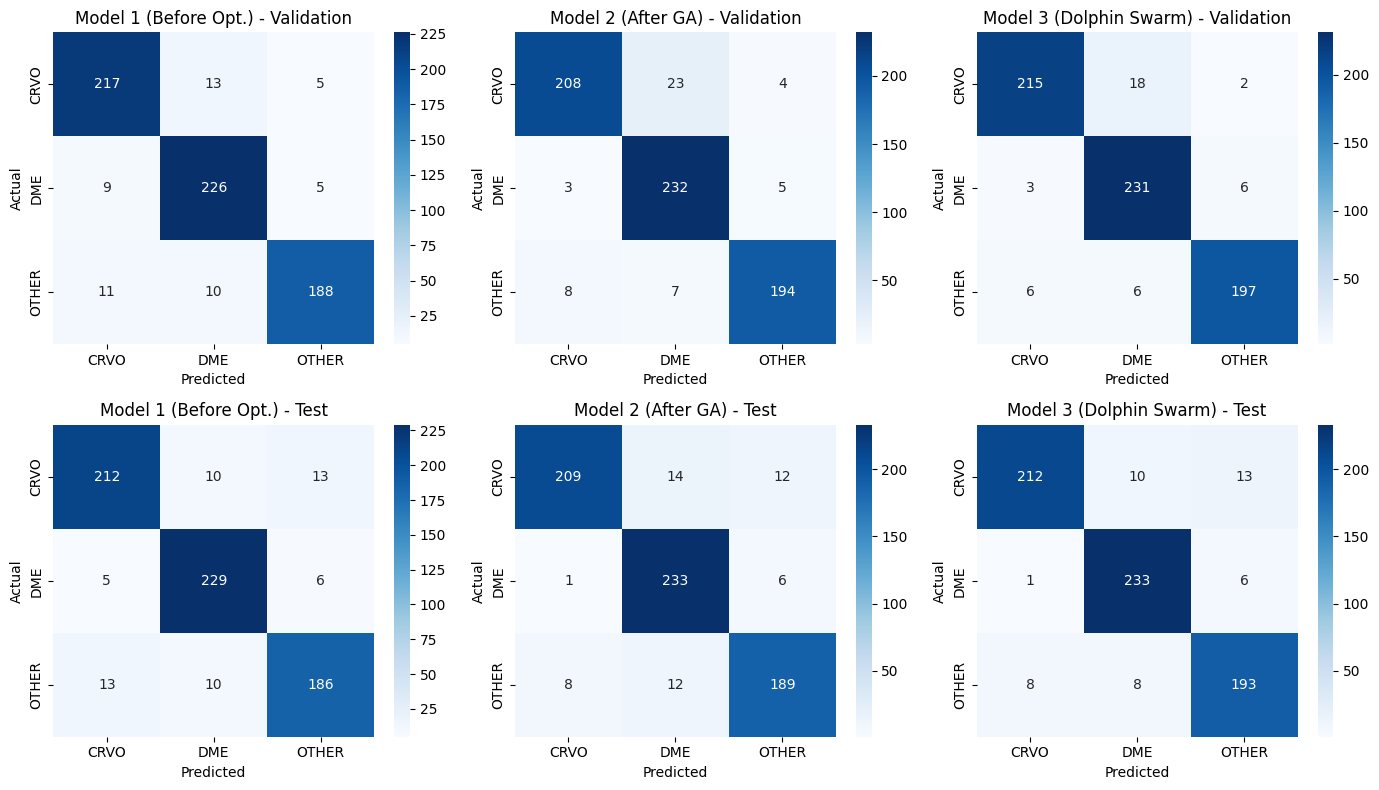

In [6]:
# -----------------------------
# Convert y_val and y_test to class labels for Accuracy/Error Rate calculation
# -----------------------------
val_true  = np.argmax(y_val, axis=1)
test_true = np.argmax(y_test, axis=1)

# ---- Model 1 ----
# Get raw predictions (probabilities)
y_pred_val_model1_raw  = model_1.predict(x_val)
y_pred_test_model1_raw = model_1.predict(x_test)
# Calculate predicted classes and metrics
val_pred_model1  = np.argmax(y_pred_val_model1_raw, axis=1)
acc_model1_val   = accuracy_score(val_true, val_pred_model1)
test_pred_model1 = np.argmax(y_pred_test_model1_raw, axis=1)
acc_model1_test  = accuracy_score(test_true, test_pred_model1)
err_model1_val   = 1 - acc_model1_val
err_model1_test  = 1 - acc_model1_test

# Get classification report (weighted average) for validation data
report_model1 = classification_report(val_true, val_pred_model1, target_names=class_names, output_dict=True)
precision_model1 = report_model1['weighted avg']['precision']
recall_model1    = report_model1['weighted avg']['recall']
f1_model1        = report_model1['weighted avg']['f1-score']
support_model1   = report_model1['weighted avg']['support']

print("\n=== Model 1 (Before Optimization) Results ===")
print(f"Validation Accuracy: {acc_model1_val:.5f}    Error Rate: {err_model1_val:.5f}")
print(f"Test Accuracy: {acc_model1_test:.5f}         Error Rate: {err_model1_test:.5f}")
print("Classification Report (Validation Data):\n", classification_report(val_true, val_pred_model1, target_names=class_names))


# ---- Model 2 ----
y_pred_val_model2_raw  = model_2.predict(x_val)
y_pred_test_model2_raw = model_2.predict(x_test)
val_pred_model2  = np.argmax(y_pred_val_model2_raw, axis=1)
acc_model2_val   = accuracy_score(val_true, val_pred_model2)
test_pred_model2 = np.argmax(y_pred_test_model2_raw, axis=1)
acc_model2_test  = accuracy_score(test_true, test_pred_model2)
err_model2_val   = 1 - acc_model2_val
err_model2_test  = 1 - acc_model2_test

report_model2 = classification_report(val_true, val_pred_model2, target_names=class_names, output_dict=True)
precision_model2 = report_model2['weighted avg']['precision']
recall_model2    = report_model2['weighted avg']['recall']
f1_model2        = report_model2['weighted avg']['f1-score']
support_model2   = report_model2['weighted avg']['support']

print("\n=== Model 2 (After GA Optimization) Results ===")
print(f"Validation Accuracy: {acc_model2_val:.5f}    Error Rate: {err_model2_val:.5f}")
print(f"Test Accuracy: {acc_model2_test:.5f}         Error Rate: {err_model2_test:.5f}")
print("Classification Report (Validation Data):\n", classification_report(val_true, val_pred_model2, target_names=class_names))


# ---- Model 3 ----
# For Model 3, extract features from Model 2 and select specified features (Dolphin Swarm - Feature Selection)
feature_extractor = tf.keras.Model(inputs=model_2.input, outputs=model_2.layers[-2].output)
val_features  = feature_extractor.predict(x_val)
test_features = feature_extractor.predict(x_test)
X_val_selected  = val_features[:, selected_indices]
X_test_selected = test_features[:, selected_indices]

y_pred_val_model3_raw  = model_3.predict(X_val_selected)
y_pred_test_model3_raw = model_3.predict(X_test_selected)
# If the output is not probabilities (i.e. a vector of class labels), then use it directly.
if y_pred_val_model3_raw.ndim > 1:
    val_pred_model3 = np.argmax(y_pred_val_model3_raw, axis=1)
else:
    val_pred_model3 = y_pred_val_model3_raw

err_model3_val = None  # Will be computed after accuracy
acc_model3_val   = accuracy_score(val_true, val_pred_model3)
err_model3_val   = 1 - acc_model3_val

if y_pred_test_model3_raw.ndim > 1:
    test_pred_model3 = np.argmax(y_pred_test_model3_raw, axis=1)
else:
    test_pred_model3 = y_pred_test_model3_raw

acc_model3_test  = accuracy_score(test_true, test_pred_model3)
err_model3_test  = 1 - acc_model3_test

report_model3 = classification_report(val_true, val_pred_model3, target_names=class_names, output_dict=True)
precision_model3 = report_model3['weighted avg']['precision']
recall_model3    = report_model3['weighted avg']['recall']
f1_model3        = report_model3['weighted avg']['f1-score']
support_model3   = report_model3['weighted avg']['support']

print("\n=== Model 3 (Dolphin Swarm - Feature Selection) Results ===")
print(f"Validation Accuracy: {acc_model3_val:.5f}    Error Rate: {err_model3_val:.5f}")
print(f"Test Accuracy: {acc_model3_test:.5f}         Error Rate: {err_model3_test:.5f}")
print("Classification Report (Validation Data):\n", classification_report(val_true, val_pred_model3, target_names=class_names))

# -----------------------------
# Create summary table (Validation Metrics Only)
# -----------------------------
summary_df = pd.DataFrame({
    'Model': ['Model 1 (Before Opt.)', 'Model 2 (After GA)', 'Model 3 (Dolphin Swarm)'],
    'Val Accuracy': [acc_model1_val, acc_model2_val, acc_model3_val],
    'Val Error Rate': [err_model1_val, err_model2_val, err_model3_val],
    'Precision': [precision_model1, precision_model2, precision_model3],
    'Recall': [recall_model1, recall_model2, recall_model3],
    'F1-Score': [f1_model1, f1_model2, f1_model3],
    'Support': [support_model1, support_model2, support_model3]
})

print("\n============================================")
print("Summary of Validation Metrics:")
print(summary_df)
print("============================================\n")

# -----------------------------
# Create confusion matrices for validation and test data for all models
# -----------------------------
cm1_val  = confusion_matrix(val_true, val_pred_model1)
cm1_test = confusion_matrix(test_true, test_pred_model1)

cm2_val  = confusion_matrix(val_true, val_pred_model2)
cm2_test = confusion_matrix(test_true, test_pred_model2)

cm3_val  = confusion_matrix(val_true, val_pred_model3)
cm3_test = confusion_matrix(test_true, test_pred_model3)

# -----------------------------
# Plot all confusion matrices in a 2x3 grid (smaller figure)
# -----------------------------
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Model 1 - Before Optimization
sns.heatmap(cm1_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
axes[0,0].set_title("Model 1 (Before Opt.) - Validation")
axes[0,0].set_xlabel("Predicted")
axes[0,0].set_ylabel("Actual")

sns.heatmap(cm1_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1,0])
axes[1,0].set_title("Model 1 (Before Opt.) - Test")
axes[1,0].set_xlabel("Predicted")
axes[1,0].set_ylabel("Actual")

# Model 2 - After GA Optimization
sns.heatmap(cm2_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,1])
axes[0,1].set_title("Model 2 (After GA) - Validation")
axes[0,1].set_xlabel("Predicted")
axes[0,1].set_ylabel("Actual")

sns.heatmap(cm2_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1,1])
axes[1,1].set_title("Model 2 (After GA) - Test")
axes[1,1].set_xlabel("Predicted")
axes[1,1].set_ylabel("Actual")

# Model 3 - Dolphin Swarm (Feature Selection)
sns.heatmap(cm3_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[0,2])
axes[0,2].set_title("Model 3 (Dolphin Swarm) - Validation")
axes[0,2].set_xlabel("Predicted")
axes[0,2].set_ylabel("Actual")

sns.heatmap(cm3_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1,2])
axes[1,2].set_title("Model 3 (Dolphin Swarm) - Test")
axes[1,2].set_xlabel("Predicted")
axes[1,2].set_ylabel("Actual")

plt.tight_layout()
plt.show()


In [7]:
# Create the summary DataFrame as before
summary_df = pd.DataFrame({
    'Model': ['Model 1 (Before Opt.)', 'Model 2 (After GA)', 'Model 3 (Dolphin Swarm)'],
    'Val Accuracy': [acc_model1_val, acc_model2_val, acc_model3_val],
    'Test Accuracy': [acc_model1_test, acc_model2_test, acc_model3_test],
    'Val Error Rate': [err_model1_val, err_model2_val, err_model3_val],
    'Test Error Rate': [err_model1_test, err_model2_test, err_model3_test],
    'Precision': [precision_model1, precision_model2, precision_model3],
    'Recall': [recall_model1, recall_model2, recall_model3],
    'F1-Score': [f1_model1, f1_model2, f1_model3],
    'Support': [support_model1, support_model2, support_model3]
})

# Convert the summary DataFrame to an HTML table
html_table = summary_df.to_html(index=False, classes='table table-bordered table-striped')

# To display in a Jupyter Notebook, you can use:
from IPython.display import HTML, display
display(HTML(html_table))


Model,Val Accuracy,Test Accuracy,Val Error Rate,Test Error Rate,Precision,Recall,F1-Score,Support
Model 1 (Before Opt.),0.922515,0.916667,0.077485,0.083333,0.923165,0.922515,0.922518,684
Model 2 (After GA),0.926901,0.922515,0.073099,0.077485,0.929020,0.926901,0.926883,684
Model 3 (Dolphin Swarm),0.940058,0.932749,0.059942,0.067251,0.941248,0.940058,0.940140,684


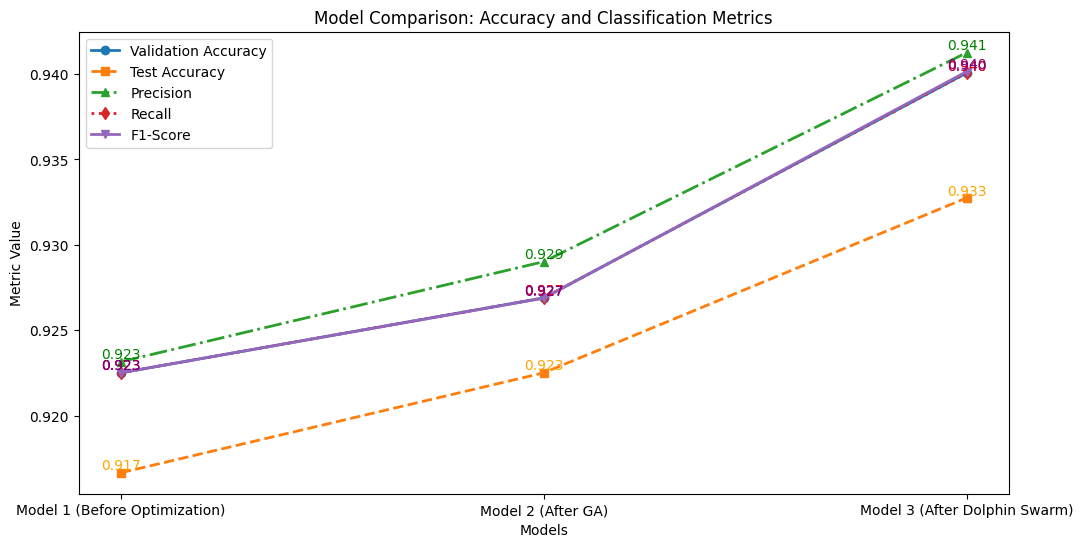

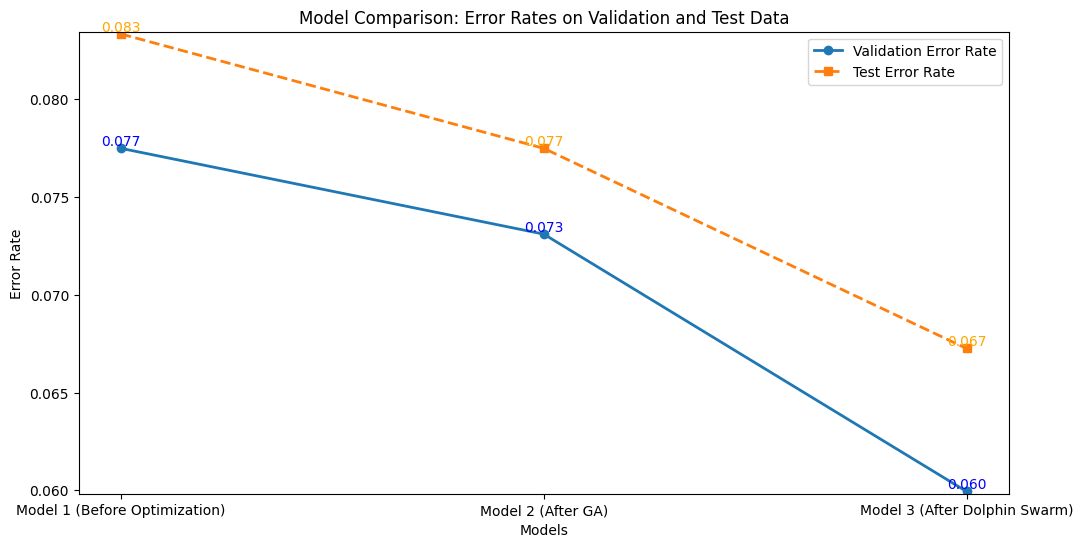

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Define the models with explicit labels in English
models_list = ['Model 1 (Before Optimization)', 'Model 2 (After GA)', 'Model 3 (After Dolphin Swarm)']

# Data for Plot 1: Accuracy and Classification Metrics
val_accs   = [acc_model1_val, acc_model2_val, acc_model3_val]
test_accs  = [acc_model1_test, acc_model2_test, acc_model3_test]
precisions = [precision_model1, precision_model2, precision_model3]
recalls    = [recall_model1, recall_model2, recall_model3]
f1_scores  = [f1_model1, f1_model2, f1_model3]

plt.figure(figsize=(12,6))
plt.plot(models_list, val_accs, marker='o', linestyle='-', linewidth=2, label='Validation Accuracy')
plt.plot(models_list, test_accs, marker='s', linestyle='--', linewidth=2, label='Test Accuracy')
plt.plot(models_list, precisions, marker='^', linestyle='-.', linewidth=2, label='Precision')
plt.plot(models_list, recalls, marker='d', linestyle=':', linewidth=2, label='Recall')
plt.plot(models_list, f1_scores, marker='v', linestyle='-', linewidth=2, label='F1-Score')
plt.xlabel('Models')
plt.ylabel('Metric Value')
plt.title('Model Comparison: Accuracy and Classification Metrics')

# Calculate dynamic y-axis limits to exaggerate small differences
all_metrics = val_accs + test_accs + precisions + recalls + f1_scores
y_min = min(all_metrics)
y_max = max(all_metrics)
margin = (y_max - y_min) * 0.05  # Increase the margin by 50% of the range
plt.ylim(y_min - margin, y_max + margin)

# Annotate each data point with its value
for i, _ in enumerate(models_list):
    plt.text(i, val_accs[i], f"{val_accs[i]:.3f}", ha='center', va='bottom', color='blue')
    plt.text(i, test_accs[i], f"{test_accs[i]:.3f}", ha='center', va='bottom', color='orange')
    plt.text(i, precisions[i], f"{precisions[i]:.3f}", ha='center', va='bottom', color='green')
    plt.text(i, recalls[i], f"{recalls[i]:.3f}", ha='center', va='bottom', color='red')
    plt.text(i, f1_scores[i], f"{f1_scores[i]:.3f}", ha='center', va='bottom', color='purple')

plt.legend()
plt.show()

# Data for Plot 2: Error Rates Comparison
val_error_rates  = [err_model1_val, err_model2_val, err_model3_val]
test_error_rates = [err_model1_test, err_model2_test, err_model3_test]

plt.figure(figsize=(12,6))
plt.plot(models_list, val_error_rates, marker='o', linestyle='-', linewidth=2, label='Validation Error Rate')
plt.plot(models_list, test_error_rates, marker='s', linestyle='--', linewidth=2, label='Test Error Rate')
plt.xlabel('Models')
plt.ylabel('Error Rate')
plt.title('Model Comparison: Error Rates on Validation and Test Data')

all_errors = val_error_rates + test_error_rates
y_min_err = min(all_errors)
y_max_err = max(all_errors)
margin_err = (y_max_err - y_min_err) * 0.005
plt.ylim(y_min_err - margin_err, y_max_err + margin_err)

# Annotate each data point with its value
for i, _ in enumerate(models_list):
    plt.text(i, val_error_rates[i], f"{val_error_rates[i]:.3f}", ha='center', va='bottom', color='blue')
    plt.text(i, test_error_rates[i], f"{test_error_rates[i]:.3f}", ha='center', va='bottom', color='orange')

plt.legend()
plt.show()


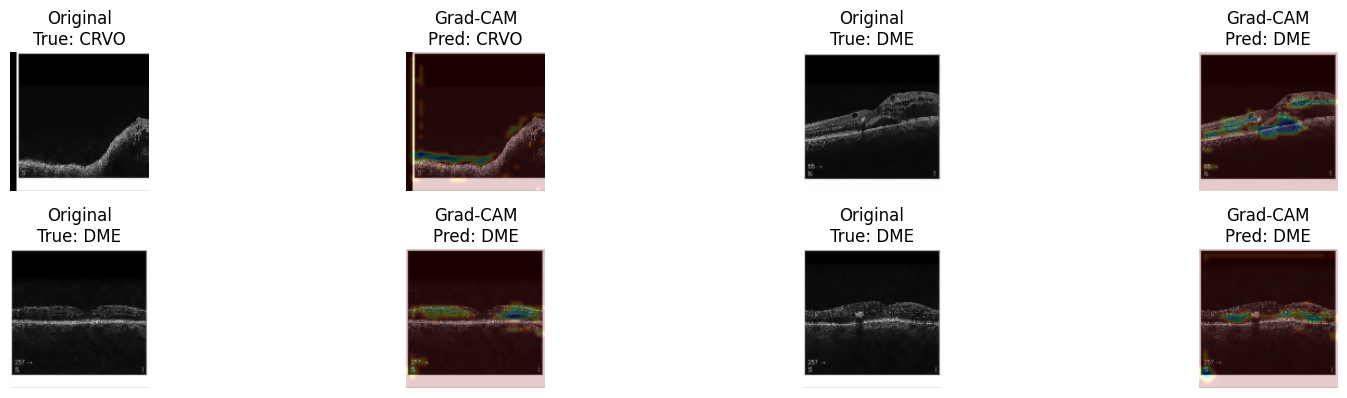

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# --- الدوال المساعدة لحساب Grad-CAM ---

def get_last_conv_layer(model):
    """تعيد اسم آخر طبقة تلافيفية في الموديل."""
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    return None

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    تنشئ خريطة Grad-CAM باستخدام الصورة والموديل واسم آخر طبقة تلافيفية.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def apply_top_percent_threshold(heatmap, top_percent=10):
    """
    تحتفظ بأعلى top_percent% من القيم في الخريطة الحرارية فقط وتضبط الباقي إلى صفر.
    """
    cutoff = np.percentile(heatmap, 100 - top_percent)
    heatmap[heatmap < cutoff] = 0.0
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
    return heatmap

def overlay_heatmap(img, heatmap, alpha=0.3):
    """
    تدمج الخريطة الحرارية مع الصورة الأصلية مع التحكم في الشفافية.
    """
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

# --- الكود الرئيسي لعرض خريطة Grad-CAM لموديل 3 فقط على شكل شبكة ---



# استخراج feature_extractor من model_2 (لاستخراج الميزات)
feature_extractor = tf.keras.Model(inputs=model_2.input, outputs=model_2.layers[-2].output)

# تحديد آخر طبقة تلافيفية في model_2
last_conv_layer_name = get_last_conv_layer(model_2)
if last_conv_layer_name is None:
    raise ValueError("لم يتم العثور على طبقة تلافيفية في model_2.")

# اختيار 10 صور عشوائياً من مجموعة الاختبار
num_images = 4
indices = np.random.choice(len(x_test), num_images, replace=False)

# إعداد شبكة عرض (5 صفوف × 4 أعمدة؛ كل صورة لها خليتان: الأصلية وGrad-CAM)
plt.figure(figsize=(16, 10))

# سيتم ترتيب الصور بحيث: 
# لكل صورتين (صورة واحدة لكل موديل) يتم عرضهما في صف واحد؛ 
# إذا كانت الصورة رقم i (0<= i < num_images) فسنقسم الصور إلى صفوف بحيث يكون:
# - إذا كان i زوجيًا: تُعرض الصورة الأصلية في العمود 1 والـ Grad-CAM في العمود 2.
# - إذا كان i فرديًا: تُعرض الصورة الأصلية في العمود 3 والـ Grad-CAM في العمود 4.
# بهذا نستخدم 5 صفوف لكل صف يحتوي على صورتين (مع كل صف يُمثل صورتين).

for i, idx in enumerate(indices):
    # الحصول على الصورة من x_test
    img = x_test[idx]
    # تحويل الصورة إلى صيغة مناسبة للعرض (إذا كانت قيمها بين 0 و 1)
    disp_img = np.uint8(255 * img) if img.max() <= 1.0 else img.astype('uint8')
    
    # تجهيز الصورة لإدخالها في الموديل (إضافة بُعد)
    img_array = np.expand_dims(img, axis=0)
    
    # حساب خريطة Grad-CAM باستخدام model_2
    heatmap = make_gradcam_heatmap(img_array, model_2, last_conv_layer_name)
    # تطبيق عتبة لإبراز أعلى 10% من القيم
    heatmap = apply_top_percent_threshold(heatmap, top_percent=10)
    # دمج الخريطة الحرارية مع الصورة الأصلية مع شفافية مخفضة
    superimposed_img = overlay_heatmap(disp_img, heatmap, alpha=0.2)
    
    # التنبؤ باستخدام موديل 3:
    features = feature_extractor.predict(img_array)
    selected_features = features[:, selected_indices]
    pred = model_3.predict(selected_features)
    pred_class = np.argmax(pred, axis=1)[0] if pred.ndim > 1 else int(pred[0])
    true_class = np.argmax(y_test[idx])
    
    # حساب موقع الخلية في الشبكة:
    # لكل صورتين نستخدم صف واحد. لنفترض أن الصور تُرتب بترتيب i=0,1,2,...,9
    # لكل صورتين: الصف = i // 2.
    # إذا كانت الصورة رقم i زوجية (i % 2 == 0)، يتم وضع الصورة الأصلية في العمود 1 والـ Grad-CAM في العمود 2.
    # وإذا كانت الصورة رقم i فردية (i % 2 == 1)، يتم وضع الصورة الأصلية في العمود 3 والـ Grad-CAM في العمود 4.
    row = i // 2
    if i % 2 == 0:
        orig_col = 0
        grad_col = 1
    else:
        orig_col = 2
        grad_col = 3
    # حساب رقم الخلية في الشبكة (مع 4 أعمدة)
    orig_pos = row * 4 + orig_col + 1
    grad_pos = row * 4 + grad_col + 1
    
    # عرض الصورة الأصلية
    plt.subplot(5, 4, orig_pos)
    plt.imshow(disp_img)
    plt.title(f"Original\nTrue: {class_names[true_class]}")
    plt.axis('off')
    
    # عرض الصورة مع خريطة Grad-CAM
    plt.subplot(5, 4, grad_pos)
    plt.imshow(superimposed_img)
    plt.title(f"Grad-CAM\nPred: {class_names[pred_class]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
